In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import json

plt.rcParams["font.family"] = "MonaspiceXe NFM"

In [2]:
# Read the data
df = pd.read_csv("table_10_05.csv", header=None)
df[0] = pd.to_datetime(df[0], format="%Y-%m-%d")
df[5] = df[0].dt.weekday

df.head()

,0,1,2,3,4,5
0,2024-10-04,25100,Chełm-Bydgoszcz Gł,Bydgoszcz Gł,PARASOL,4
1,2024-10-05,3534,Kraków Gł-Bydgoszcz Gł,Bydgoszcz Gł,PARASOL,5
2,2024-10-05,81110,Piła Gł-Warszawa Wsch,Piła Gł,WALIZKA / PLECAK,5
3,2024-10-05,21102,Lublin Gł. - Warszawa Zach.,WARSZAWA CENTR.,TELEFON,5
4,2024-10-05,35170,Zakopane - Gdynia Gł.,GDYNIA GŁ.,REKLAMÓWKA / TORBA,5


In [3]:
corrections = json.load(open("./corrections.txt"))

df[4] = df[4].str.title()
df[3] = df[3].str.title()
df[3] = df[3].replace(corrections)

# sorted(df[3].dropna().astype(str).unique())

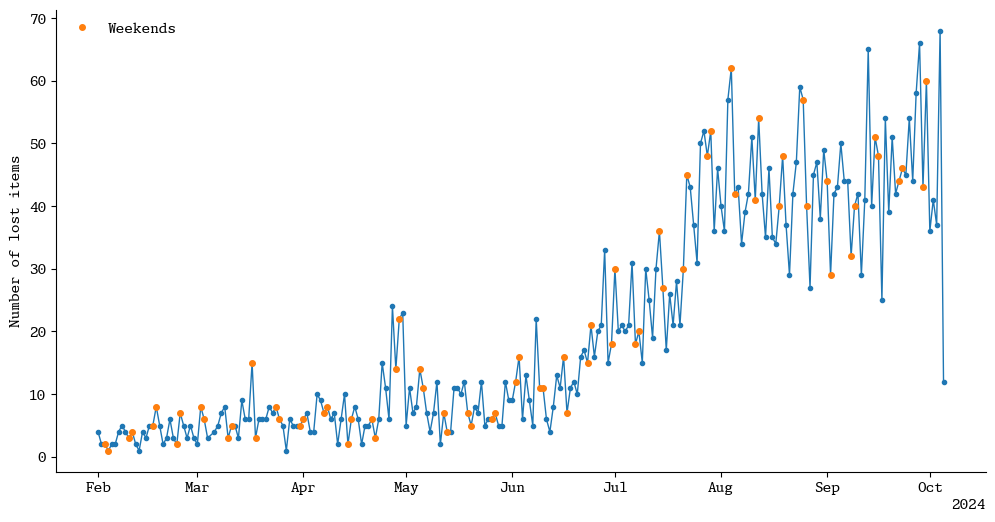

In [4]:
# Items lost in time, with weekends highlighted

counts = df.groupby(0).count()[1]

date = counts.index
val = counts.values

fig, ax = plt.subplots(1, figsize=(12,6))

ax.plot(date, val, lw=1, marker=".")
ax.plot(date[2::7], val[2::7], lw=0, marker=".", c="tab:orange", ms=8, label="Weekends")
ax.plot(date[3::7], val[3::7], lw=0, marker=".", c="tab:orange", ms=8)

ax.set_ylabel("Number of lost items")

ax.spines[['right', 'top']].set_visible(False)

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.legend(frameon=False)

plt.savefig("./img/number_of_lost_items_weekends.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

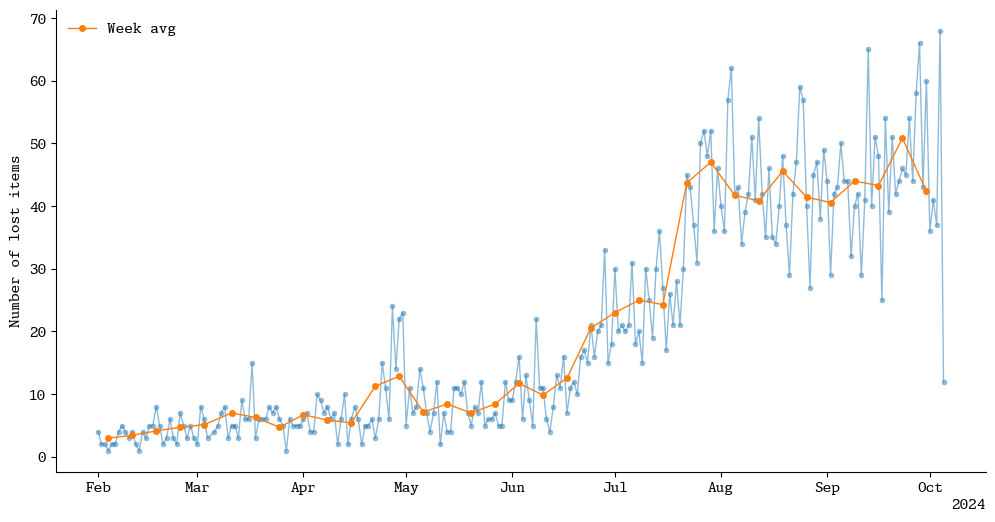

In [5]:
# Items lost in time, with weekly average 

counts = df.groupby(0).count()[1]

date = counts.index
val = counts.values

# get the weekly average
weeks = []

for i in range(3, len(val), 7):
    weeks.append(val[i:i+7].mean())

# plot
fig, ax = plt.subplots(1, figsize=(12,6))

ax.plot(date, val, lw=1, marker=".", alpha=0.5, markeredgecolor='none', ms=8)
ax.plot(date[3::7], weeks, label="Week avg", lw=1, marker=".", c="tab:orange", ms=8)

ax.set_ylabel("Number of lost items")

ax.spines[['right', 'top']].set_visible(False)

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.legend(frameon=False)

plt.savefig("./img/number_of_lost_items.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

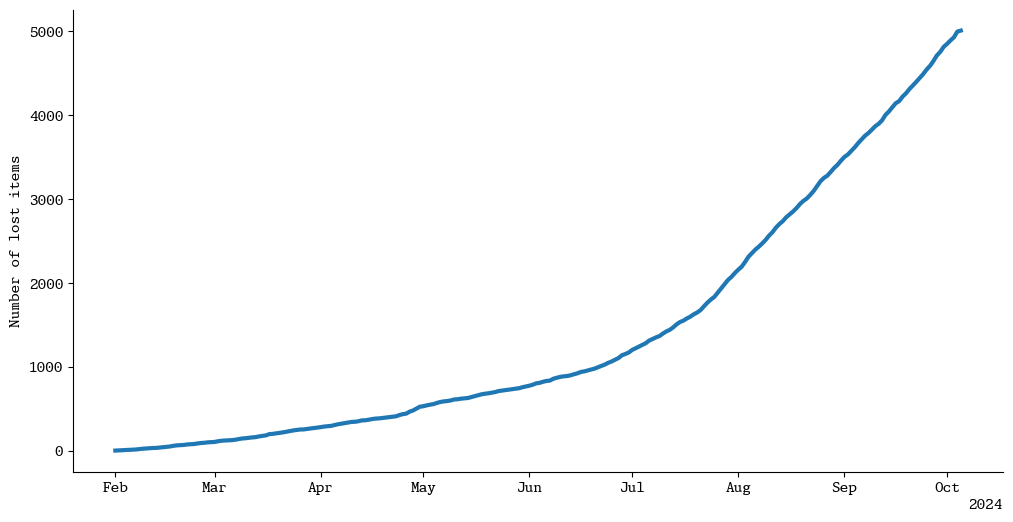

In [6]:
# Cummulative 

counts = df.groupby(0).count()[1]

date = counts.index
val = counts.values

# plot
fig, ax = plt.subplots(1, figsize=(12,6))

ax.plot(date, np.cumsum(val), lw=3, marker="", alpha=1, markeredgecolor='none', ms=8)
ax.set_ylabel("Number of lost items")

ax.spines[['right', 'top']].set_visible(False)

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.savefig("./img/number_of_lost_items_cum.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

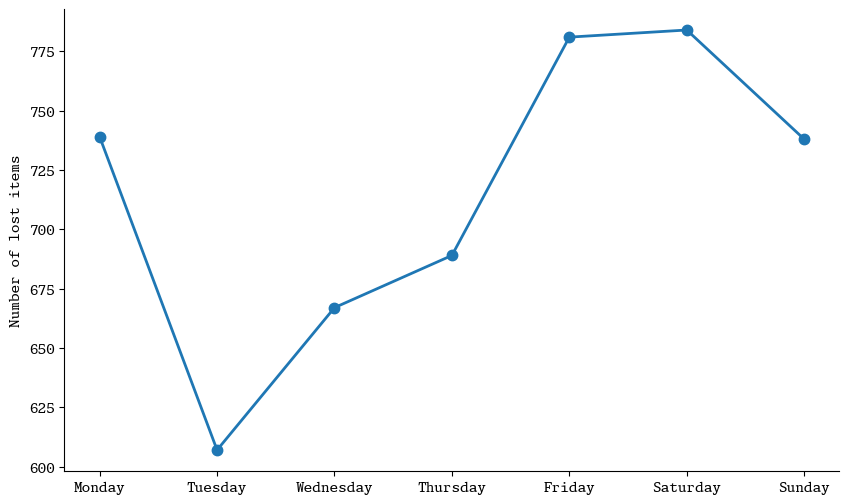

In [7]:
# Weekly distribution

dayofweek = df.groupby(5).count()[1]

dow = dayofweek.index
dow_val = dayofweek.values

dow = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(dow, dow_val, lw=2, marker=".", ms=15)

ax.set_ylabel("Number of lost items")

ax.spines[['right', 'top']].set_visible(False)

plt.savefig("./img/day_of_week.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [8]:
def fill_with_zero(df):
    """
    Fill missing dates with zero
    """
    idx = pd.date_range('02-01-2024', '10-04-2024')

    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)

    return df

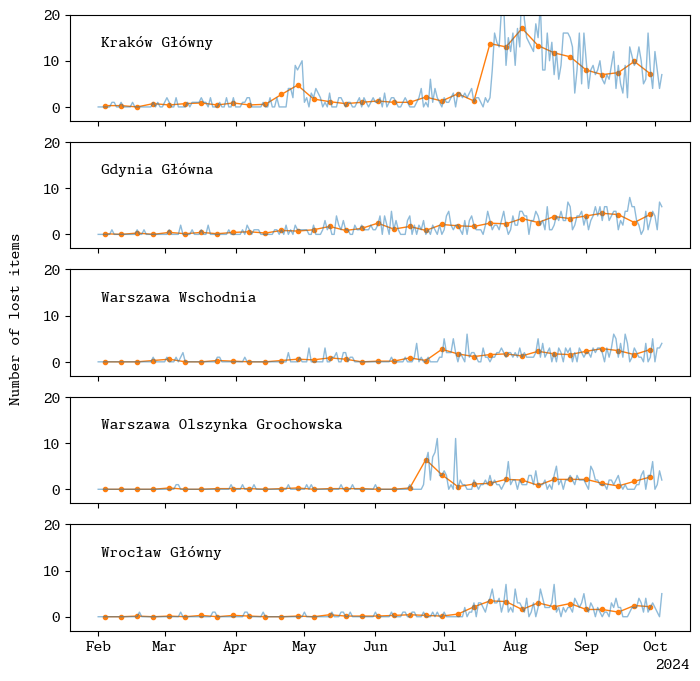

In [9]:
# Top N cities with items lost and the distribution in time

N = 5

fig, axes = plt.subplots(N,1, sharex=True, figsize=(8,8))

for i in range(N):
    city = df[3].value_counts().index[i]
    
    dane = df[df[3]==city][0].value_counts()

    dane = fill_with_zero(dane)
    
    idx = dane.index.argsort()
    
    date = dane.index[idx]
    val = dane.values[idx]

    # get the weekly average
    weeks = []
    
    for j in range(3, len(val), 7):
        weeks.append(val[j:j+7].mean())

    axes[i].plot(date[3::7], weeks, lw=1, marker=".", c="tab:orange", ms=6)
        
    axes[i].plot(date, val, lw=1, marker="", alpha=0.5)
    
    axes[i].set_ylim(-3, 20)
    
    axes[i].annotate(city, xy=(0.05,0.7), xycoords='axes fraction')
    
    axes[i].xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    
fig.text(0.05, 0.5, 'Number of lost items', va='center', rotation='vertical')

plt.savefig("./img/cities.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

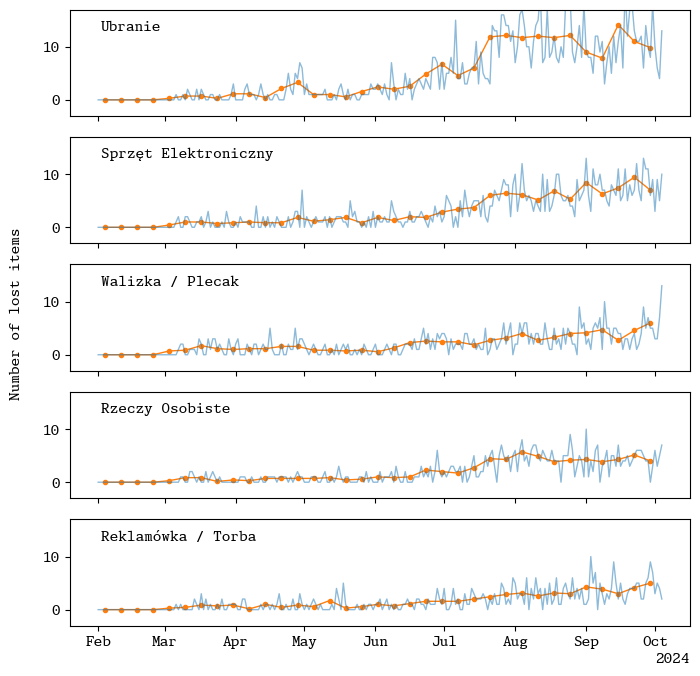

In [10]:
# Top N items lost and the distribution in time

N = 5

fig, axes = plt.subplots(N,1, sharex=True, figsize=(8,8))

for i in range(N):
    item = df[4].value_counts().index[i]
    
    dane = df[df[4]==item][0].value_counts()
    
    dane = fill_with_zero(dane)
    
    idx = dane.index.argsort()
    
    date = dane.index[idx]
    val = dane.values[idx]

    # get the weekly average
    weeks = []

    for j in range(3, len(val), 7):
        weeks.append(val[j:j+7].mean())

    axes[i].plot(date[3::7], weeks, lw=1, marker=".", c="tab:orange", ms=6)
        
    axes[i].plot(date, val, lw=1, marker="", alpha=0.5)
    
    axes[i].set_ylim(-3, 17)
    
    axes[i].annotate(item, xy=(0.05,0.9), xycoords='axes fraction', ha='left', va='top')

    axes[i].xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

fig.text(0.05, 0.5, 'Number of lost items', va='center', rotation='vertical')

plt.savefig("./img/items.svg", bbox_inches='tight', transparent=True, pad_inches=0)

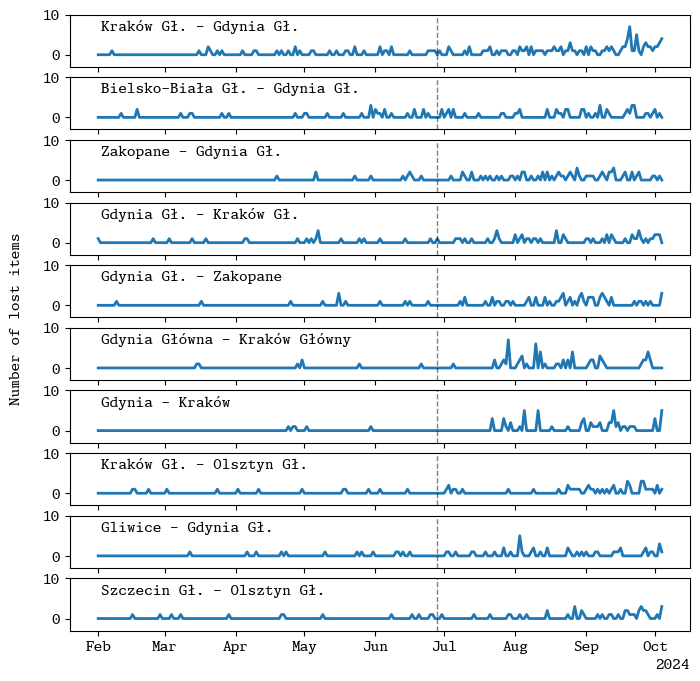

In [11]:
# Top N routes with lost items and the distribution in time

N = 10

fig, axes = plt.subplots(N,1, sharex=True, figsize=(8,8))

for i in range(N):
    route = df[2].value_counts().index[i]
    
    dane = df[df[2]==route][0].value_counts()

    dane = fill_with_zero(dane)
    
    idx = dane.index.argsort()
    
    date = dane.index[idx]
    val = dane.values[idx]
        
    axes[i].plot(date, val, lw=2, marker="")
    
    axes[i].set_ylim(-3, 10)
    
    axes[i].annotate(route, xy=(0.05,0.7), xycoords='axes fraction')
    
    axes[i].xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    axes[i].axvline(pd.to_datetime('2024-6-28'), lw=1, c="black", ls="--", alpha=0.5)

fig.text(0.05, 0.5, 'Number of lost items', va='center', rotation='vertical')

plt.savefig("./img/routes.svg", bbox_inches='tight', transparent=True, pad_inches=0)

In [12]:
# Look for correlation between items and cities

N = 20
M = 20

cities = df[3].value_counts().index[:M].values
items = df[4].value_counts().index[:N].values

corr = []

for i in range(N):
    tmp = []
    for j in range(M):
        tmp.append(df.loc[df[4].eq(items[i]) & df[3].eq(cities[j])][0].count())

    corr.append(tmp)

corr = np.array(corr)

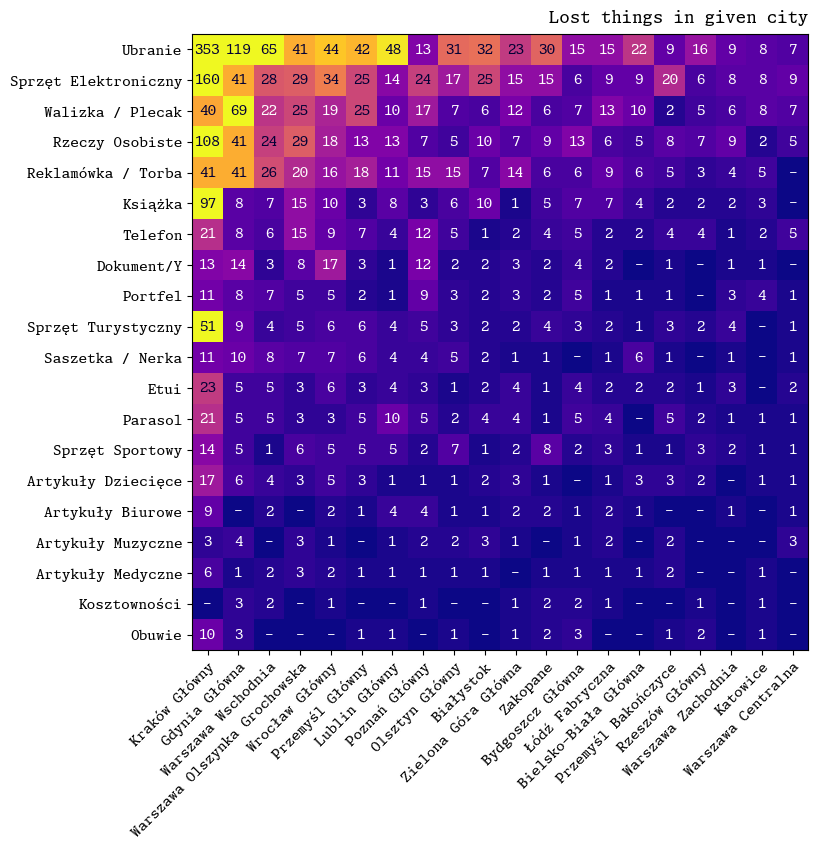

In [13]:
# Total number of items lost in biggest cities

fig, ax = plt.subplots(figsize=(8,8))

percent = (corr.transpose()/df[4].value_counts().values[:N]).transpose()

ax.imshow(corr, cmap="plasma", vmax=50)
# ax.imshow(corr, vmax=50)

ax.set_xticks(np.arange(M), labels=cities)
ax.set_yticks(np.arange(N), labels=items)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(N):
    for j in range(M):
        if corr[i, j] < 23 and corr[i, j] >= 1:
            text = ax.text(j, i, f"{corr[i, j]:.0f}",
                           ha="center", va="center", color="w", size=10)
        elif corr[i, j] < 1:
            text = ax.text(j, i, f"-",
               ha="center", va="center", color="w", size=10)
        else:
            text = ax.text(j, i, f"{corr[i, j]:.0f}",
                           ha="center", va="center", color="xkcd:midnight blue", size=10)

ax.set_title("Lost things in given city", loc="right", va="bottom")

plt.savefig("./img/lost_things_in_city.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

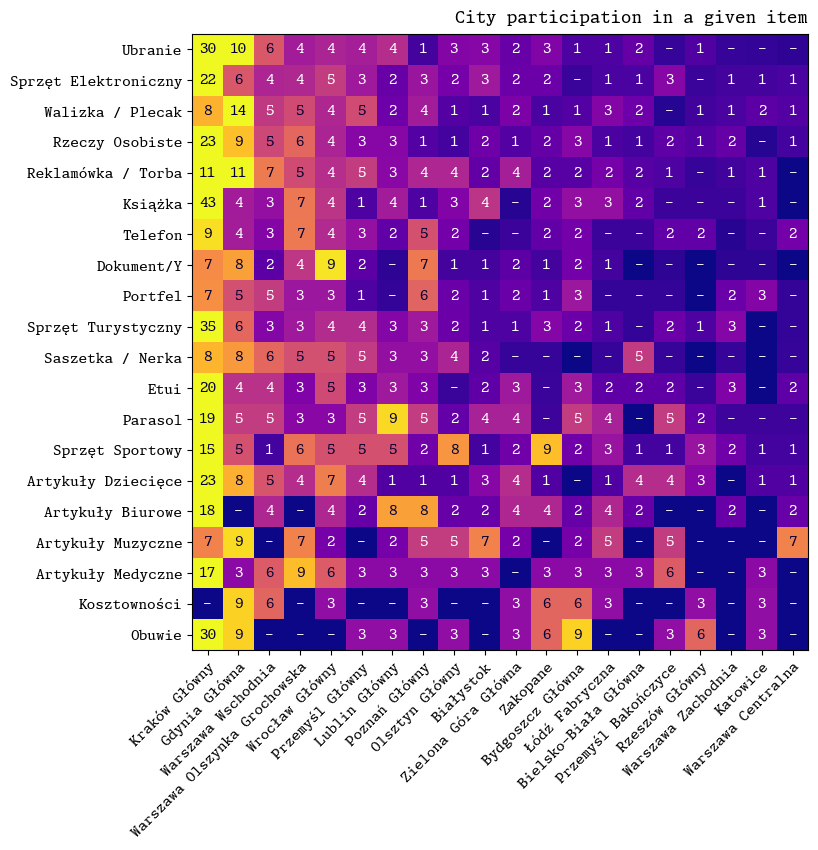

In [14]:
# City participation in a given item [percent]

fig, ax = plt.subplots(figsize=(8,8))

percent = (corr.transpose()/df[4].value_counts().values[:N]).transpose()

ax.imshow(percent, cmap="plasma", vmax=0.1)
# ax.imshow(corr, vmax=50)

ax.set_xticks(np.arange(M), labels=cities)
ax.set_yticks(np.arange(N), labels=items)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(N):
    for j in range(M):
        if percent[i, j] < 0.01:
            text = ax.text(j, i, f"-",
               ha="center", va="center", color="w", size=10)
        elif percent[i, j] <= 0.05:
            text = ax.text(j, i, f"{percent[i, j]*100:.0f}",
                           ha="center", va="center", color="w", size=10)
        else:
            text = ax.text(j, i, f"{percent[i, j]*100:.0f}",
                           ha="center", va="center", color="xkcd:midnight blue", size=10)

ax.set_title("City participation in a given item", loc="right", va="bottom")

plt.savefig("./img/city_participation.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

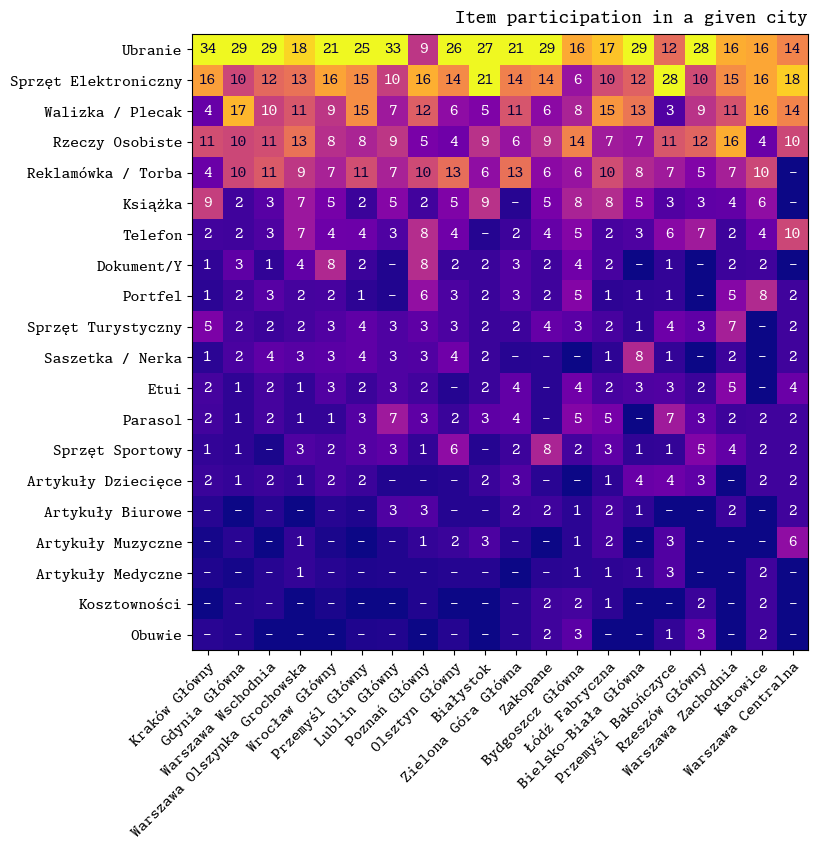

In [15]:
# Item participation in a given city [percent

fig, ax = plt.subplots(figsize=(8,8))

percent = corr/df[3].value_counts().values[:N]

ax.imshow(percent, cmap="plasma", vmax=0.2)
# ax.imshow(corr, vmax=50)

ax.set_xticks(np.arange(M), labels=cities)
ax.set_yticks(np.arange(N), labels=items)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(N):
    for j in range(M):
        if percent[i, j] < 0.01:
            text = ax.text(j, i, f"-",
               ha="center", va="center", color="w", size=10)
        elif percent[i, j] <= 0.1:
            text = ax.text(j, i, f"{percent[i, j]*100:.0f}",
                           ha="center", va="center", color="w", size=10)
        else:
            text = ax.text(j, i, f"{percent[i, j]*100:.0f}",
                           ha="center", va="center", color="xkcd:midnight blue", size=10)

ax.set_title("Item participation in a given city", loc="right", va="bottom")

plt.savefig("./img/item_participation.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()